In [8]:
%load_ext autoreload
%autoreload 2
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
os.chdir('/tmldata1/andriush/auto-sharpness-dev')
from utils_notebooks import subsample_metrics_dict
%matplotlib inline
sns.set(font_scale=1.1)

np.random.seed(1)
# np.set_printoptions(precision=6, suppress=True)
np.set_printoptions()
plot_height = 10
marker_size, line_width = 3.5, 2.0
label_size, legend_size = 15, 13



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
def dataset_gaussians_binary(v_global, n, d, std):
    v = v_global.copy()
    v /= (v**2).sum()**0.5  # make it unit norm
    mu_zero, mu_one = v, -v

    x = np.concatenate([mu_zero + std*np.random.randn(n // 2, d), mu_one + std*np.random.randn(n // 2, d)])
    y = np.concatenate([-np.ones(n // 2), np.ones(n // 2)])
    indices = np.random.permutation(np.arange(n))
    x, y = x[indices], y[indices]
    return x, y


def grad_logloss_w(x, y, w):
    f = x @ w
    loss_der = -y / (1 + np.exp(f*y))
    return np.mean(loss_der[:, None] * x, 0) 


def logloss(x, y, w, weight_norm=False, logit_normalization=False):
    if weight_norm:
        w = w / (w**2).sum()**0.5
    f = x @ w
    if logit_normalization:
        f = np.sign(f)
    return np.mean(np.log(1 + np.exp(-f*y)))


def logloss_sam_m_1(x, y, w, rho, weight_norm=False, rho_weight_norm_fraction=False, logit_normalization=False):
    if weight_norm:
        w = w / (w**2).sum()**0.5
    if rho_weight_norm_fraction:
        rho = rho * (w**2).sum()**0.5
    f = x @ w
    worst_margin = f*y - rho*np.sum(x**2, 1)**0.5
    if logit_normalization:
        worst_margin = np.sign(worst_margin)
    worst_loss = np.mean(np.log(1 + np.exp(-worst_margin)))
    return worst_loss



In [10]:
n_train, n_test = 50, 1000
d = 100
std = 0.025
eps_train = eps_test = 0.85
frac_ln = 0.0
n_iters = 100  # 4000
test_err_flag = False
color_erm, color_sam = 'red', 'blue'
at_weight_space = True

test_err_flag = True
np.random.seed(0)

v_global = np.random.randn(d)

x_all, y_all = dataset_gaussians_binary(v_global, n_train+n_test, d, std)
x_train, y_train = x_all[:n_train], y_all[:n_train]
# y_train[:int(frac_ln*n_train)] *= -1  # introduce label noise by flipping labels
x_test, y_test = x_all[n_train:], y_all[n_train:]

w_init = np.random.randn(d) / 500
# w_init /= (w_init**2).sum()**0.5

print('err for w_init: {:.2%}'.format((np.sign(x_test @ w_init) != y_test).mean()))    

# for at_type in ['standard']: 
alpha = 5.0

w = w_init.copy()
best_train_err, best_test_err = np.inf, np.inf
train_iters, train_errs, test_errs = list(), list(), list()
for i in range(n_iters):    
    train_loss = logloss(x_train, y_train, w)
    test_loss = logloss(x_test, y_test, w)
    train_err = ((y_train * (x_train @ w) - eps_train*(w**2).sum()**0.5) < 0.0).mean()
    test_err = ((y_test * (x_test @ w) - eps_test*(w**2).sum()**0.5) < 0.0).mean()
    if train_err < best_train_err:
        best_train_err = train_err
    if test_err < best_test_err:
        best_test_err = test_err
    
    every_k = 1
    if i % every_k == 0 or i < 20:
        train_iters.append(i)
        train_errs.append(train_err)
        test_errs.append(test_err)
    if i % 20 == 0 or i == n_iters-1:
        # margins = y_train * (x_train @ w)
        # print(margins[:int(frac_ln*n_train)].mean(), margins[int(frac_ln*n_train):].mean())
        print('iter={}: loss={:.3f}/{:.3f}, err={:.1%}/{:.1%} (best_err={:.1%}/{:.1%})'.format(i, train_loss, test_loss, train_err, test_err, best_train_err, best_test_err))
    
    w = w - alpha * grad_logloss_w(x_train, y_train, w)


err for w_init: 0.00%
iter=0: loss=0.692/0.692, err=100.0%/100.0% (best_err=100.0%/100.0%)
iter=20: loss=0.009/0.009, err=0.0%/0.0% (best_err=0.0%/0.0%)
iter=40: loss=0.005/0.005, err=0.0%/0.0% (best_err=0.0%/0.0%)
iter=60: loss=0.003/0.003, err=0.0%/0.0% (best_err=0.0%/0.0%)
iter=80: loss=0.002/0.002, err=0.0%/0.0% (best_err=0.0%/0.0%)
iter=99: loss=0.002/0.002, err=0.0%/0.0% (best_err=0.0%/0.0%)


In [11]:
loss = logloss(x_train, y_train, w)
print('||w||_2={:.4f}, loss={:.4f}'.format((w**2).sum()**0.5, loss))
for rho in [0.5]:
    max_loss = logloss_sam_m_1(x_train, y_train, w, rho)
    print('max_loss={:.4f}, sharpness={:.4f}'.format(max_loss, max_loss - loss))
  

||w||_2=6.2469, loss=0.0020
max_loss=0.0033, sharpness=0.0013


In [12]:
np.sign(x_train @ w)

array([-1., -1., -1., -1., -1.,  1.,  1., -1.,  1.,  1., -1.,  1.,  1.,
       -1., -1.,  1., -1.,  1.,  1.,  1., -1., -1., -1.,  1.,  1., -1.,
       -1.,  1., -1., -1.,  1., -1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,
       -1., -1.,  1.,  1., -1.,  1., -1., -1., -1.,  1.,  1.])

alpha=0.00, max_loss=0.6917, sharpness=0.0016
alpha=0.01, max_loss=0.6771, sharpness=0.0167
alpha=0.12, max_loss=0.5323, sharpness=0.1379
alpha=1.27, max_loss=0.0212, sharpness=0.0208
alpha=13.86, max_loss=0.0000, sharpness=0.0000
alpha=151.31, max_loss=0.0000, sharpness=0.0000
alpha=1024.00, max_loss=0.0000, sharpness=0.0000
alpha=0.00, max_loss=0.6909, sharpness=0.0008
alpha=0.01, max_loss=0.6687, sharpness=0.0083
alpha=0.12, max_loss=0.4592, sharpness=0.0649
alpha=1.27, max_loss=0.0028, sharpness=0.0024
alpha=13.86, max_loss=0.0000, sharpness=0.0000
alpha=151.31, max_loss=0.0000, sharpness=0.0000
alpha=1024.00, max_loss=0.0000, sharpness=0.0000
alpha=0.00, max_loss=0.6904, sharpness=0.0003
alpha=0.01, max_loss=0.6637, sharpness=0.0033
alpha=0.12, max_loss=0.4193, sharpness=0.0250
alpha=1.27, max_loss=0.0008, sharpness=0.0005
alpha=13.86, max_loss=0.0000, sharpness=0.0000
alpha=151.31, max_loss=0.0000, sharpness=0.0000
alpha=1024.00, max_loss=0.0000, sharpness=0.0000


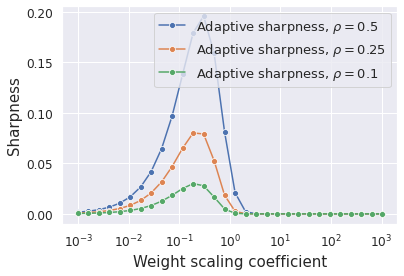

In [21]:
weight_norm = False
adaptive_sharpness = True
logit_normalization = False
for rho in [0.1, 0.25, 0.5][::-1]:
    n_alphas = 30
    alphas = np.logspace(-10, 10, num=n_alphas, base=2)  
    sharpness_vals = []
    for i, alpha in enumerate(alphas):
        loss = logloss(x_train, y_train, alpha*w, weight_norm=weight_norm, logit_normalization=logit_normalization)
        max_loss = logloss_sam_m_1(x_train, y_train, alpha*w, rho, weight_norm=weight_norm, rho_weight_norm_fraction=adaptive_sharpness, logit_normalization=logit_normalization)
        sharpness_vals.append(max_loss - loss)
        # sharpness_vals.append((max_loss - loss) / (1 + loss))
        if i % 5 == 0 or i == n_alphas-1:
            print('alpha={:.2f}, max_loss={:.4f}, sharpness={:.4f}'.format(alpha, max_loss, sharpness_vals[-1]))
    
    ax = sns.lineplot(x=alphas, y=sharpness_vals, marker='o', label='Adaptive sharpness, $\\rho={}$'.format(rho))

# ax.set_ylim(0.12, 0.4)
ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlabel('Weight scaling coefficient', size=label_size)
ax.set_ylabel('Sharpness', size=label_size)
ax.legend(loc='best', fontsize=legend_size)
plt.savefig('plots/linear_model_sharpness.pdf', bbox_inches='tight')
plt.show()


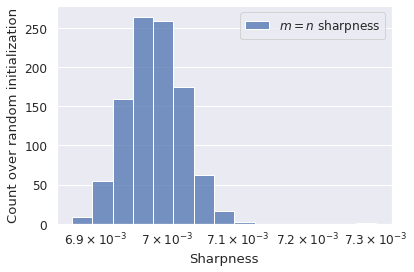

In [14]:
def logloss_sam_m_n(x, y, w, rho, n_iters=100, weight_norm=False, rho_weight_norm_fraction=True, verbose=False):
    if weight_norm:
        w = w / (w**2).sum()**0.5
    if rho_weight_norm_fraction:
        rho = rho * (w**2).sum()**0.5

    alpha = 2 / n_iters * rho
    max_loss = logloss(x, y, w)
    # delta = np.zeros_like(w)
    delta = np.random.randn(w.shape[0])
    delta /= (delta**2).sum()**0.5 
    for i in range(n_iters):
        grad = grad_logloss_w(x, y, w+delta)
        grad_norm = (grad**2).sum()**0.5
        if grad_norm < 10**-10:
            print('warning: grad norm is {} (<10^-10)'.format(grad_norm))
        delta = delta + alpha / grad_norm * grad_logloss_w(x, y, w+delta)
        delta_norm = (delta**2).sum()**0.5
        if delta_norm > rho:
            delta = rho / delta_norm * delta
        loss = logloss(x, y, w+delta)
        if loss > max_loss:
            max_loss = loss
        if verbose and i % 5 == 0:
            print(loss)
    return max_loss

# logloss_sam_m_1(x_train, y_train, w, rho, weight_norm=False, rho_weight_norm_fraction=True)
np.random.seed(0)
rho = 0.25
n_repeat = 1000
weight_norm = False
n_ex = 50

for n_iters in [100]:
    sharpness_vals = []
    for i in range(n_repeat):
        loss = logloss(x_train[:n_ex], y_train[:n_ex], w, weight_norm=weight_norm)
        max_loss = logloss_sam_m_n(x_train[:n_ex], y_train[:n_ex], w, rho, n_iters, weight_norm=weight_norm, rho_weight_norm_fraction=True, verbose=False)
        sharpness_vals.append(max_loss - loss)
        # print('sharpness', sharpness_vals[-1])
    
    ax = sns.histplot(x=sharpness_vals, bins=15, log_scale=True, label='$m=n$ sharpness')
    # ax.set_yscale('log')
    # plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    ax.set_xlabel('Sharpness')
    ax.set_ylabel('Count over random initialization')
    ax.legend(loc='best')
    plt.savefig('plots/histogram_sharpness_m_n.pdf', bbox_inches='tight')
    plt.show()
    